In [ ]:
import polars as pl
import pandas as pd
import os
ROOT = os.path.join(os.getcwd(),'ariel-data-challenge-2025')
star_info = pd.read_csv(os.path.join(ROOT,'train_star_info.csv'))
train_csv = pd.read_csv(os.path.join(ROOT,'train.csv'))
wavelengths = pd.read_csv(os.path.join(ROOT,'wavelengths.csv')) 

In [ ]:
print(wavelengths)
print()

   wl_1      wl_2      wl_3     wl_4      wl_5      wl_6      wl_7      wl_8  \
0   0.7  1.951761  1.960612  1.96945  1.978273  1.987083  1.995879  2.004661   

      wl_9     wl_10  ...   wl_274   wl_275    wl_276   wl_277    wl_278  \
0  2.01343  2.022184  ...  3.84972  3.85481  3.859887  3.86495  3.869999   

     wl_279    wl_280    wl_281    wl_282    wl_283  
0  3.875034  3.880055  3.885063  3.890056  3.895036  

[1 rows x 283 columns]


In [17]:
import glob

path_folder = os.path.join(os.getcwd(),'ariel-data-challenge-2025')
files = glob.glob(os.path.join(path_folder,'train/', '*/*'))

print(len(files))


4840


In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
planet_signal_0 = np.load(os.path.join('tmp','data_light_raw','104891231_0_signal_v1.npy'))



In [2]:
def playAnimation(data, sensor):

    
    total_flux = np.nansum(data, axis=(1, 2))
    # Key frame indices (quarter-points + first/last)
    base_frames = [len(data)*i//100 for i in range(100)]+[len(data)-1]

    # Find brightest and darkest frame indices
    brightest_idx = np.argmax(total_flux)
    darkest_idx = np.argmin(total_flux)

    # Add to the frame list, avoiding duplicates
    extra_frames = []
    for idx in [brightest_idx, darkest_idx]:
        if idx not in base_frames and (idx != -1 and idx != len(data)-1):
            extra_frames.append(idx)
    frames = base_frames + extra_frames
    frames = sorted(frames)

    # Set up clean styling
    plt.style.use('default')
    if sensor == 'FGS1':
        fig, ax = plt.subplots(figsize=(10, 6))
        vmin, vmax = np.nanpercentile(data[0], [1, 99])
        ax.set_title("Frame 0")
        im = ax.imshow(data[frames[0]], cmap='hot', aspect='equal', vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
        title_text = ax.text(0.5, 1.05, "", transform=ax.transAxes, ha="center", va="bottom", fontsize=11)
    elif sensor == 'AIRS':    
        fig, ax = plt.subplots(figsize=(10, 3))
        vmin, vmax = np.nanpercentile(data[0], [1, 99])
        ax.set_title("Frame 0")
        im = ax.imshow(data[frames[0]], cmap='auto', aspect='equal', vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
        title_text = ax.text(0.5, 1.05, "", transform=ax.transAxes, ha="center", va="bottom", fontsize=11)
        

        

    # Atualiza cada frame da animação
    def update(i):
        idx = frames[i]
        frame = data[idx]
        im.set_array(data[idx])

        vmin, vmax = np.nanpercentile(frame, [2, 98])
        im.set_clim(vmin, vmax)
        
        time_min = idx * 0.1 / 60
        if idx == brightest_idx:
            title = f'Brightest\nT={time_min:.1f} min'
        elif idx == darkest_idx:
            title = f'Darkest\nT={time_min:.1f} min'
        else:
            title = f'T={time_min:.1f} min'
        title_text.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
        return [im, title_text]
    
    ani = FuncAnimation(fig, update, frames=len(frames), blit=True, repeat = False)
    plt.close(fig)
    return ani
    



In [ ]:
# gaussian derivatives
def dgauss(sig):
    xs = np.arange(-3.*sig, 3.*sig+1)
    den = 2.*sig*sig
    ys = np.exp(-np.square(xs)/den)
    dys = -2*xs/den*ys
    return dys

def d2gauss(sig):
    xs = np.arange(-3.*sig, 3.*sig+1)
    den = 2.*sig*sig
    ys = np.exp(-np.square(xs)/den)
    d2ys = np.square(2/den)*ys*(xs-sig)*(xs+sig)
    return d2ys

def find_transit_edges(S, sigma):
    """ Find the centers of the transitions """

    Sc = np.convolve(S, dgauss(sigma), mode="valid")
    off = int((S.size-Sc.size)/2)
    mid = Sc.size//2

    transit_start = np.argmin(Sc[3:mid-3])+off+3
    transit_end = np.argmax(Sc[mid+3:-3])+off+mid+3

    return transit_start, transit_end

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def find_transit_slopes(S, transit_start, transit_end, sigma):
    """find the width of the transitions"""
    
    Sc2 = np.convolve(S, d2gauss(sigma), mode="valid")
    off = int((S.size-Sc2.size)/2)

    t1 = transit_start - off
    t2 = transit_end - off
    print(off)
    sz = 2*sigma
    t1a = np.argmin(Sc2[t1-sz:t1+1])+t1-sz+off
    t1b = np.argmax(Sc2[t1:t1+sz+1])+t1+off
    t2a = np.argmax(Sc2[t2-sz:t2+1])+t2-sz+off
    t2b = np.argmin(Sc2[t2:t2+sz+1])+t2+off

    return t1a, t1b, t2a, t2b

In [ ]:
from scipy.optimize import curve_fit

def cosine_kernel(window_length, power=2):
    x = np.linspace(-np.pi, np.pi, window_length)
    kernel = np.cos(x / 2)**power
    kernel /= kernel.sum()  
    return kernel

def apply_cosine_smoothing(signal, window_length=21, power=2):
    kernel = cosine_kernel(window_length, power)
    
    half = window_length // 2
    
    # Faz padding nas bordas replicando os valores mais próximos
    padded = np.pad(signal, pad_width=half, mode='edge')
    
    # Junta tudo
    smoothed = np.convolve(padded, kernel, mode='valid')
    smoothed = smoothed[:len(signal)]
    return smoothed

def replace_outliers_with_smoothing(signal, smoothed, sigma=3):
    diff = np.abs(signal - smoothed)
    threshold = sigma * np.std(diff)
    outliers = diff > threshold
    corrected = signal.copy()
    corrected[outliers] = smoothed[outliers]

    return corrected, outliers

def transit_line(ax, x, color, name):
    ax.axvline(x, color=color, linestyle="--", alpha=0.7, label=name)
    ax.plot(x, S[int(x)], 'o', color=color)

def var_name(var, namespace):
    for name, val in namespace.items():
        if id(val) == id(var):
            return name
    return "Unknown"

In [32]:
SIGMA = 60
def seeMeanIntensityAIRS(signal, wl):
    mean_flux = signal[wl]
    mean_flux /= mean_flux.mean()
    window = 42
    smoothed_flux = apply_cosine_smoothing(mean_flux, window_length=window, power=2)

    corrected, outliers = replace_outliers_with_smoothing(mean_flux, smoothed_flux, sigma=6)
    corrected_smooth = apply_cosine_smoothing(corrected, window_length=window, power=2)
    transit_start, transit_end = find_transit_edges(corrected_smooth, SIGMA)
    t1a, t1b, t2a, t2b = find_transit_slopes(corrected_smooth, transit_start, transit_end, SIGMA)

    point_list = [transit_start, transit_end, t1a, t1b, t2a, t2b]
    color_list = ['green', 'brown', 'red', 'red', 'blue', 'blue']
    name_list = ['Transit Start', 'Transit End', 'Entrance Beggining', 'Entrance End', 'Exit Beggining', 'Exit End']

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(mean_flux, label='Original', alpha=0.3)
    ax.plot(corrected_smooth, label='Corrigido + Suavizado', linewidth=2, color='black')
    ax.scatter(np.where(outliers)[0], mean_flux[outliers], color='red', s=15, label='Outliers')

    for name, value, clr in zip(name_list, point_list, color_list):
        ax.axvline(value, color=clr, linestyle="--", alpha=0.7, label=name)
        ax.plot(value, corrected_smooth[int(value)], 'o', color=clr)

    ax.set_title("Correção + Suavização com Marcação Pós-Outliers")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

0
(5625,) (5625,)


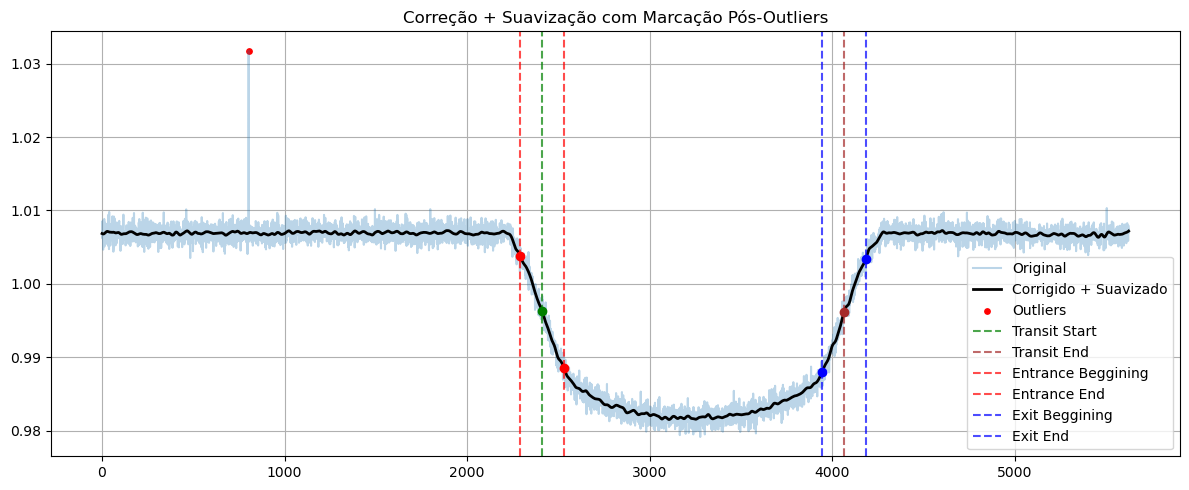

28
(5625,) (5625,)


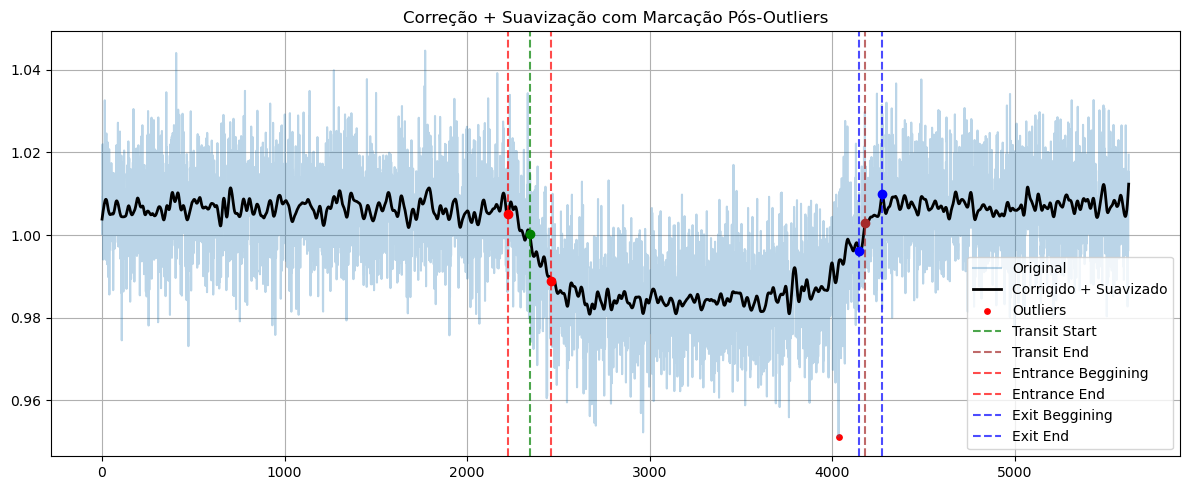

56
(5625,) (5625,)


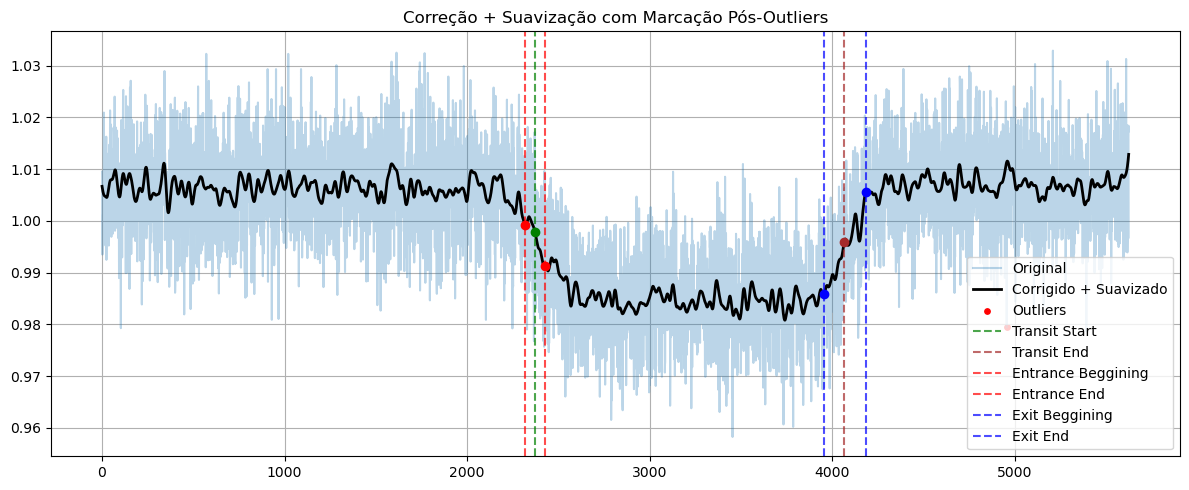

84
(5625,) (5625,)


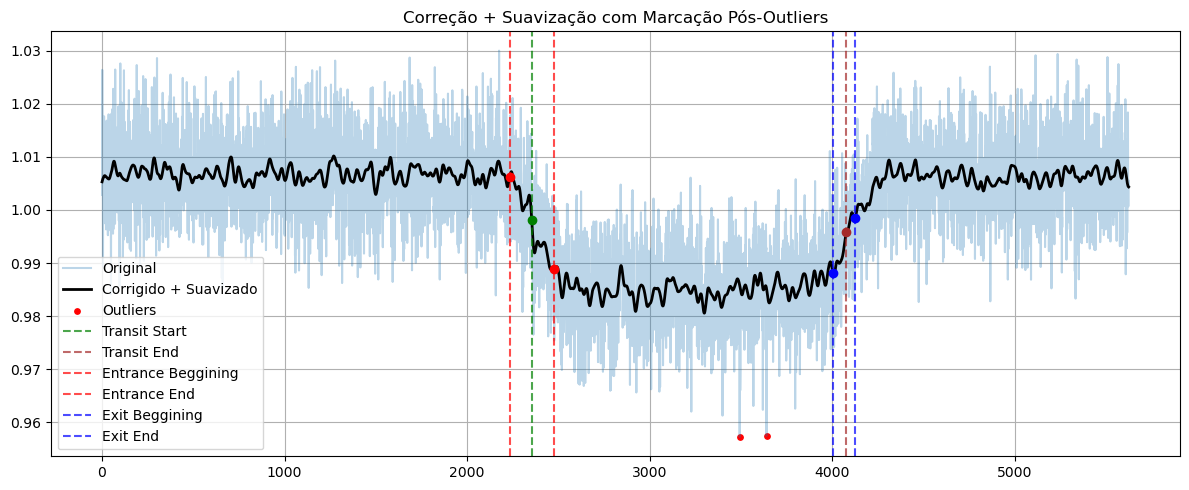

112
(5625,) (5625,)


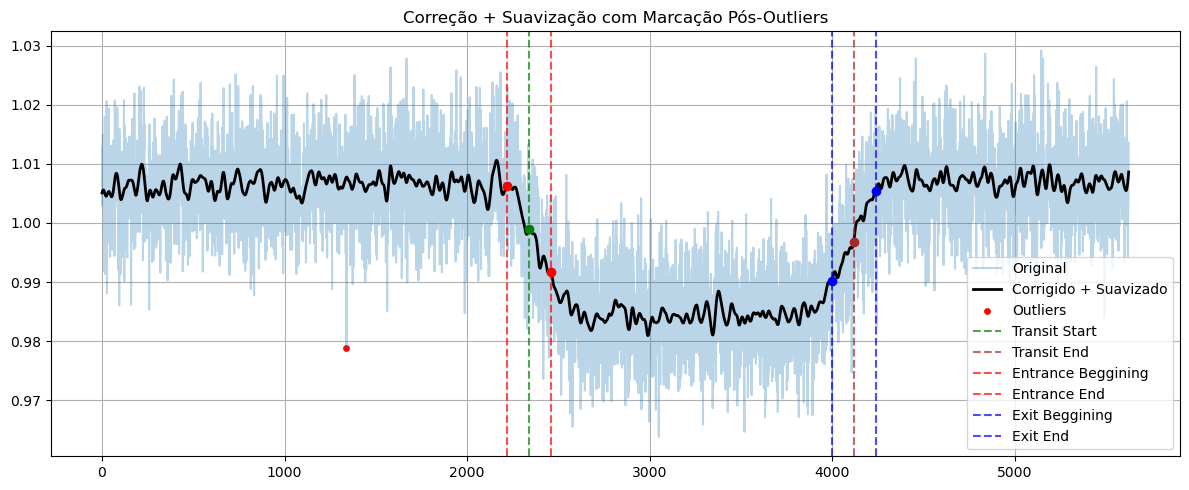

141
(5625,) (5625,)


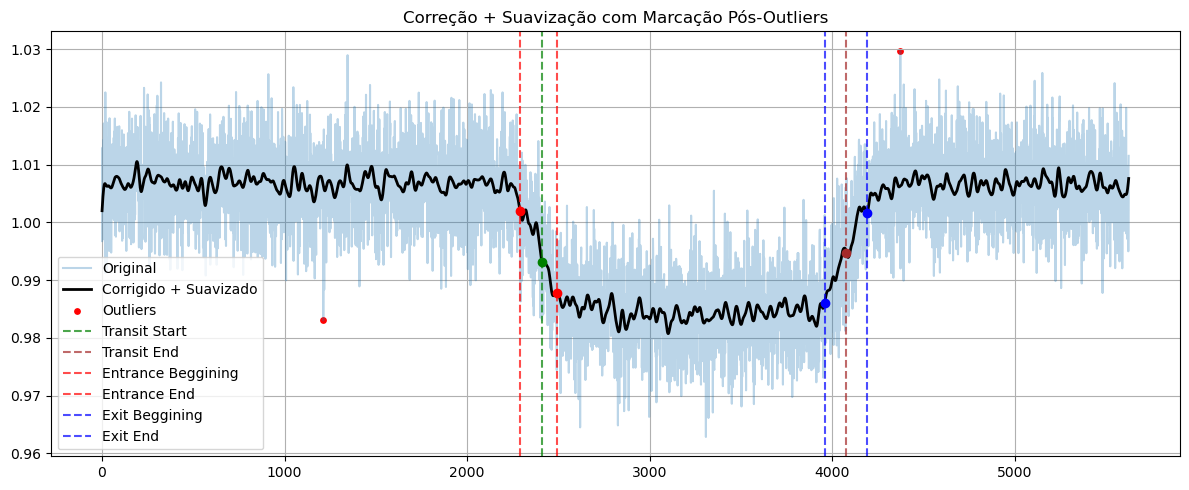

169
(5625,) (5625,)


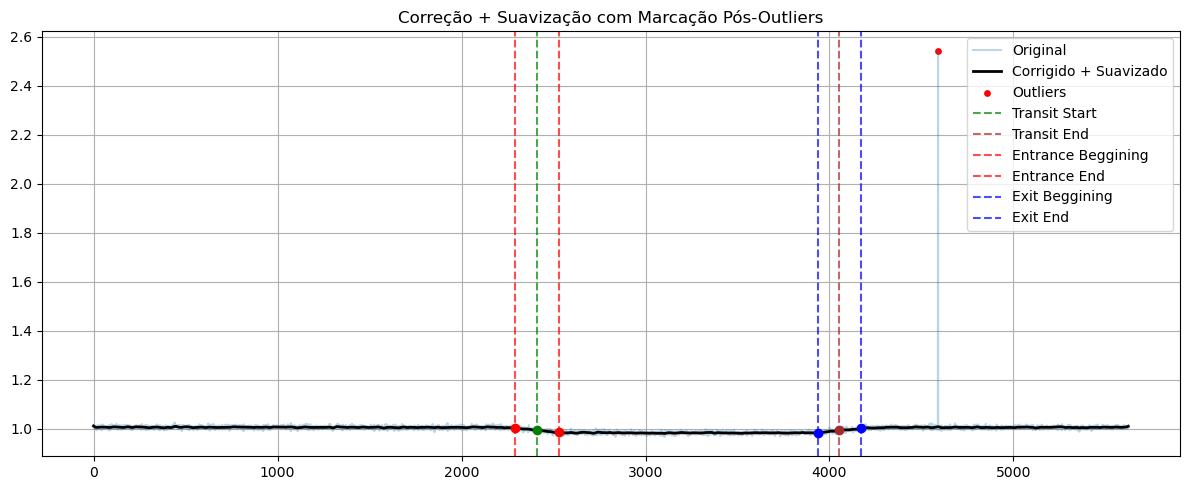

197
(5625,) (5625,)


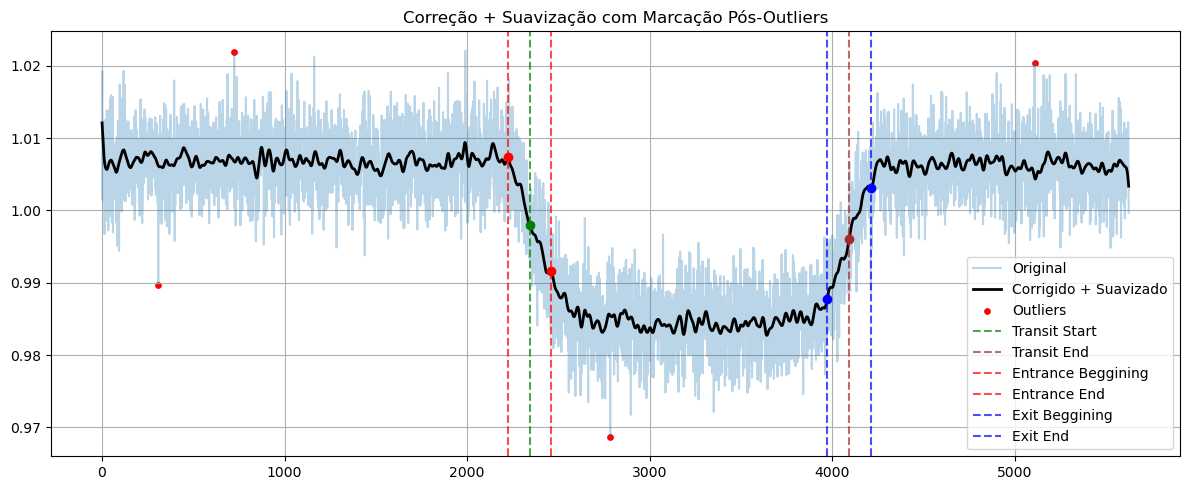

225
(5625,) (5625,)


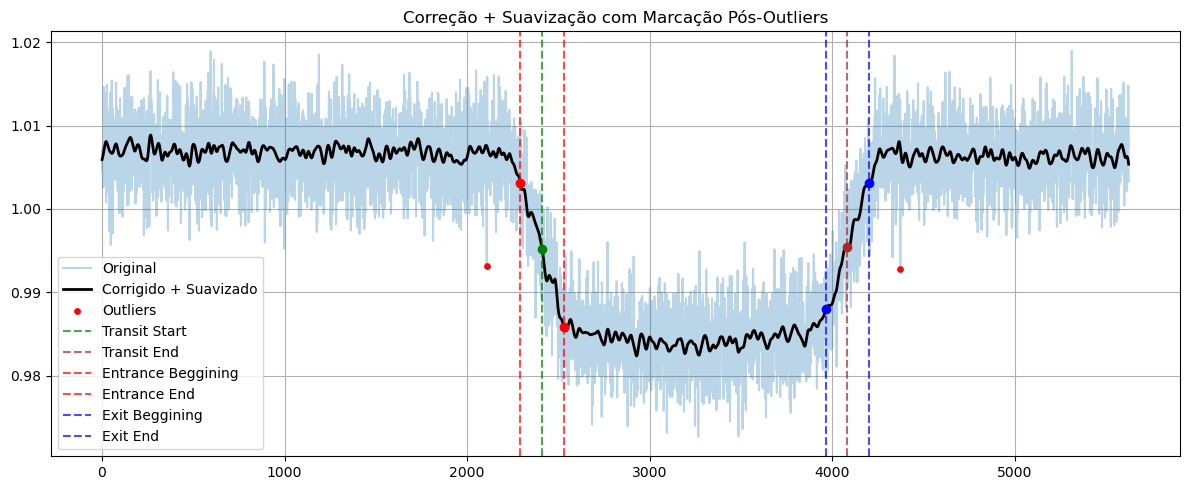

253
(5625,) (5625,)


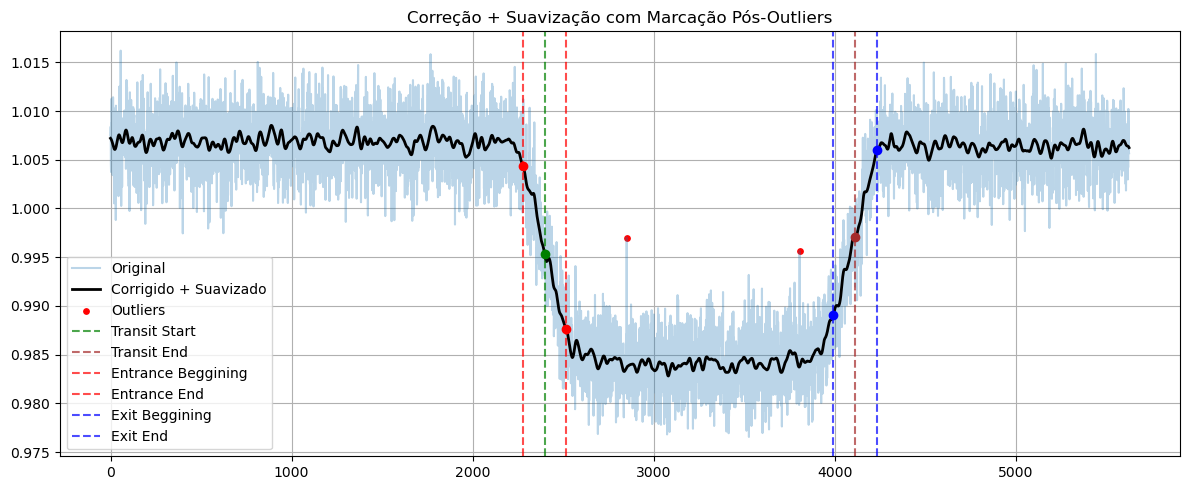

282
(5625,) (5625,)


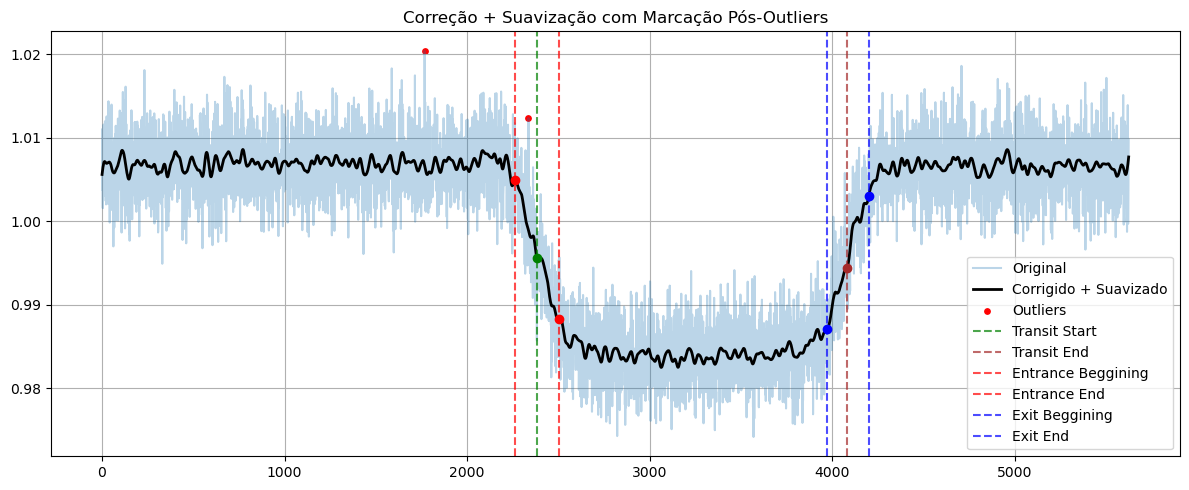

In [31]:
wls = [282*i//10 for i in range(11)]
for wl in wls:
    print(wl)
    seeMeanIntensityAIRS(planet_signal_0, wl)

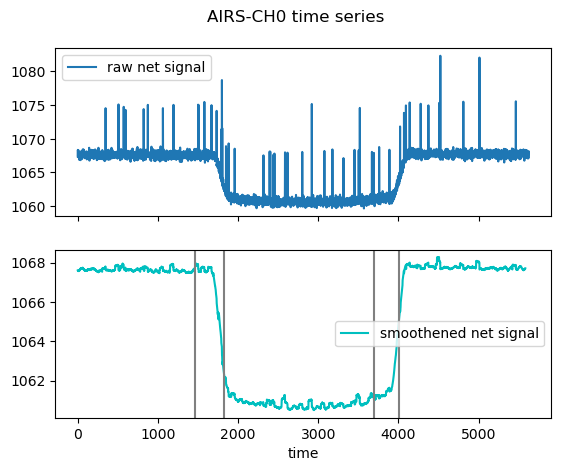

In [36]:
seeMeanIntensityAIRS(AIRS_signal_1)